In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.interpolate import LinearNDInterpolator
from torch_geometric.transforms import delaunay
from scipy.spatial import Delaunay
import cmocean
import seaborn as sns
sns.set(style="whitegrid")

USER = os.getenv('USER')

In [2]:
def area(x0, y0, x1, y1, x2, y2):
    """
    jac = jacobian(x0, y0, x1, y1, x2, y2):
    calculates jac = det(M),
    where M is the matrix
    [[x1-x0, y1-y0], [x2-x0, y2-y0]].

    This is twice the area of a triangle with vertices:
    (x0, y0), (x1, y1), (x2, y2)

    Parameters:
    x0, x1, x2 (numpy arrays or floats) - x coords of the 3 points
    y0, y1, y2 (numpy arrays or floats) - y coords of the 3 points

    Returns:
    jac (same type as inputs)
    """
    return (x1-x0)*(y2-y0)-(x2-x0)*(y1-y0)

In [3]:
# find matching coordinates on the first and second snapshots

#nfile0 = f'../../example_data/field_20230101T120000Z.npz'
nfile0 = '/home/frop/Documents/NTNU/Sea_Ice_ML/week_data/field_20230102T000000Z.npz'
d0 = dict(np.load(nfile0))
#nfile1 = f'../../example_data/field_20230101T230000Z.npz'
nfile1 = '/home/frop/Documents/NTNU/Sea_Ice_ML/week_data/field_20230102T030000Z.npz'
d1 = dict(np.load(nfile1))

file0 = dict(np.load('../../../week_data/' + sorted(os.listdir('../../../week_data'))[0]))
file_final = dict(np.load('../../../week_data/' + sorted(os.listdir('../../../week_data'))[-1]))

# find common nodes on the first and the second files
_, comm0, comm1 = np.intersect1d(d0['i'], d1['i'], assume_unique=True, return_indices=True)

# get common X, Y coordinates
x0 = d0['x'][comm0]
y0 = d0['y'][comm0]
x1 = d1['x'][comm1]
y1 = d1['y'][comm1]

In [4]:
pos = np.stack([x0,y0],axis=1)
t0 = Delaunay(pos,qhull_options='QJ').simplices


In [5]:
# create subsampled mesh for matching nodes only
#t0 = Triangulation(x0, y0).triangles
# find starting / ending coordinates for each elements
x0a, x0b, x0c = x0[t0].T
y0a, y0b, y0c = y0[t0].T
x1a, x1b, x1c = x1[t0].T
y1a, y1b, y1c = y1[t0].T

In [6]:
# compute area at the first and second snapshots (subsampled mesh)
a0 = area(x0a, y0a, x0b, y0b, x0c, y0c)
a1 = area(x1a, y1a, x1b, y1b, x1c, y1c)

(141344,)


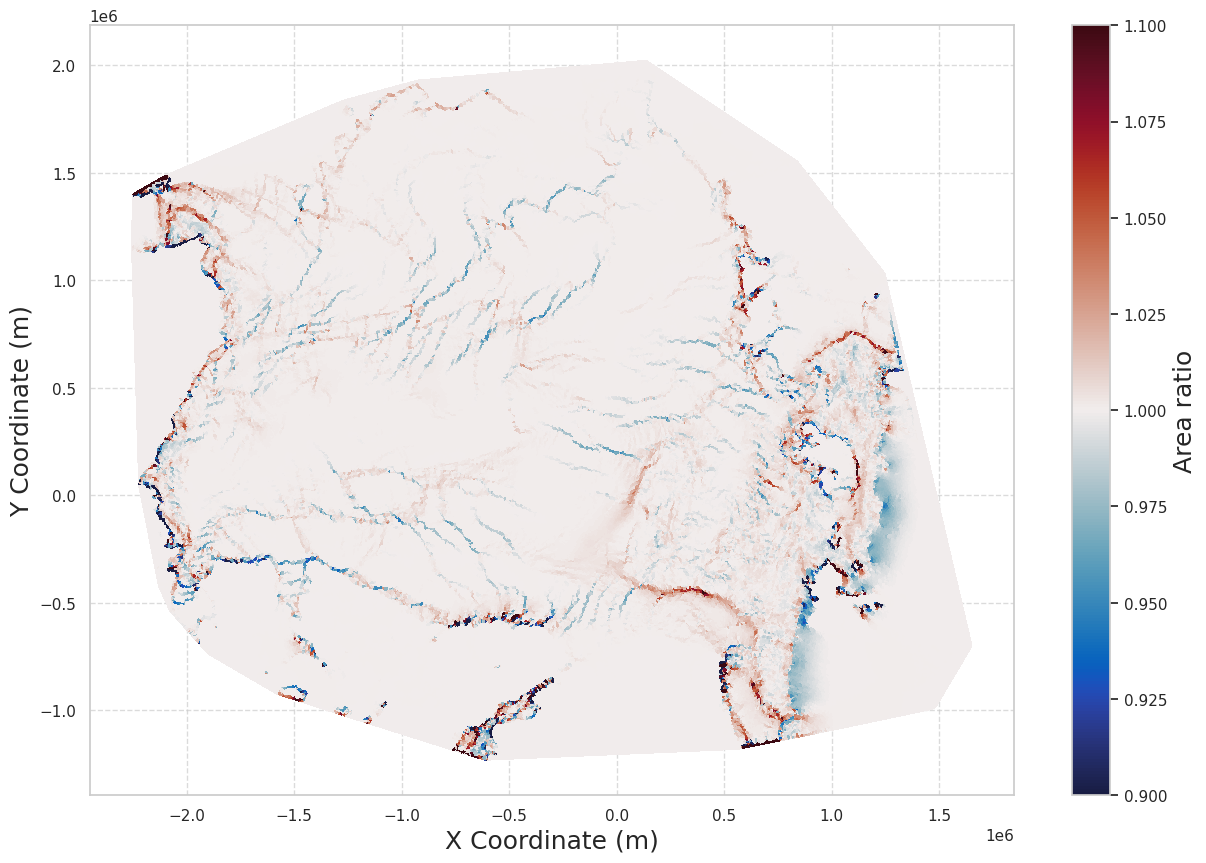

In [7]:
# plot ratio of areas (subsampled mesh)
plt.figure(figsize=(15,10))
area_ratio = np.clip(a0 / a1, 0.4, 1.3)
print(area_ratio.shape)
plt.tripcolor(x0, y0, area_ratio, triangles=t0, vmin=0.9, vmax=1.1,cmap=cmocean.cm.balance)
#colorbar with font size 18
cbar0 = plt.colorbar(orientation='vertical')
cbar0.set_label('Area ratio', fontsize=18)
#plt.xlim([0.9e6, 1.25e6])
#plt.ylim([-0.15e6, 0e6])
plt.gca().set_aspect('equal')
plt.xlabel('X Coordinate (m)', fontsize=18)
plt.ylabel('Y Coordinate (m)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
#remove axis
#plt.axis('off')

In [8]:
# original mesh data at time 0
sit0 = d0['Thickness']
sic0 = d0['Concentration']
t0n = d0['t']
x0n = d0['x']
y0n = d0['y']
elx0n = x0n[t0n].mean(axis=1)
ely0n = y0n[t0n].mean(axis=1)

In [9]:
# interpolate SIC from original mesh elements to the subsampled mesh elements
x0e = x0[t0].mean(axis=1)
y0e = y0[t0].mean(axis=1)

sit_interpolator = LinearNDInterpolator((elx0n, ely0n), sit0)
sit0 = sit_interpolator((x0e, y0e))

sic_interpolator = LinearNDInterpolator((elx0n, ely0n), sic0)
sic0 = sic_interpolator((x0e, y0e))

In [10]:
# new SIC (after convergence / divergence) (subsampled mesh)
sit1comp = sit0 * area_ratio
sic1comp = np.clip(sic0 * area_ratio,0,1)



In [11]:
# original mesh data at time 1
sit1 = d1['Thickness']
sic1 = d1['Concentration']
t1n = d1['t']
x1n = d1['x']
y1n = d1['y']
elx1n = x1n[t1n].mean(axis=1)
ely1n = y1n[t1n].mean(axis=1)

In [12]:
# interpolate SIC computed with divergence from subsampled mesh to original mesh at time 1
x1e = x1[t0].mean(axis=1)
y1e = y1[t0].mean(axis=1)

sit_comp_interpolator = LinearNDInterpolator((x1e, y1e), sit1comp)
sit01comp = sit_comp_interpolator((elx1n, ely1n))

sic_comp_interpolator = LinearNDInterpolator((x1e, y1e), sic1comp)
sic01comp = sic_comp_interpolator((elx1n, ely1n))

In [13]:
# interpolate SIC WITHOUT accounting divergence from subsampled mesh to original mesh at time 1
sit_interpolator = LinearNDInterpolator((x1e, y1e), sit0)
sit01 = sit_interpolator((elx1n, ely1n))

sic_interpolator = LinearNDInterpolator((x1e, y1e), sic0)
sic01 = sic_interpolator((elx1n, ely1n))

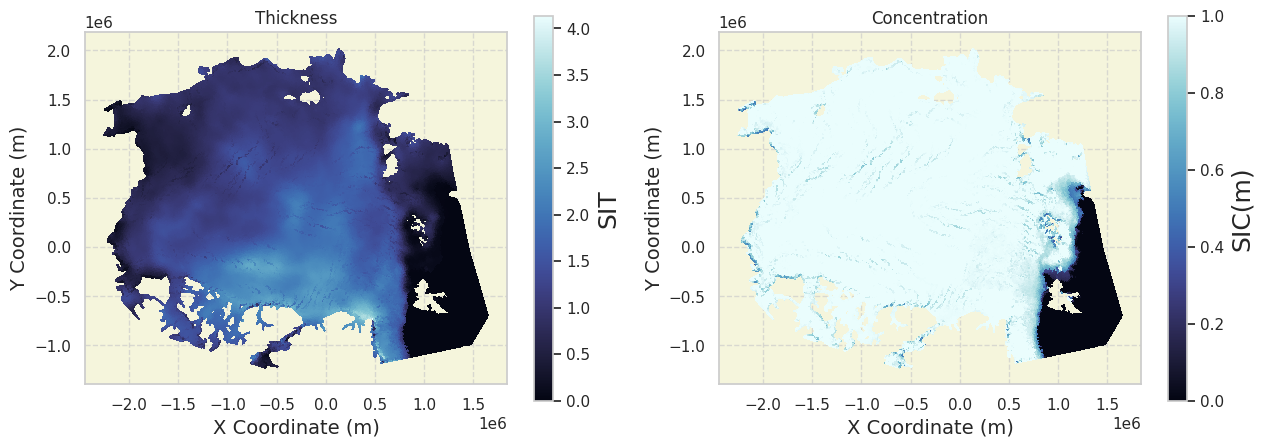

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
im0 = ax[0].tripcolor(x1n, y1n, sit01comp, triangles=t1n, cmap=cmocean.cm.ice)
ax[0].set_title('Thickness')
ax[0].set_xlabel('X Coordinate (m)', fontsize=14)
ax[0].set_ylabel('Y Coordinate (m)', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].set_aspect('equal')
ax[0].set_facecolor('#f5f5dc')
plt.colorbar(im0, ax=ax[0], orientation='vertical', shrink=0.5).set_label('SIT', fontsize=18)


im1 = ax[1].tripcolor(x1n, y1n, sic01comp, triangles=t1n, cmap=cmocean.cm.ice)
ax[1].set_title('Concentration')
ax[1].set_xlabel('X Coordinate (m)', fontsize=14)
ax[1].set_ylabel('Y Coordinate (m)', fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].set_aspect('equal')
ax[1].set_facecolor('#f5f5dc')
plt.colorbar(im1, ax=ax[1], orientation='vertical', shrink=0.5).set_label('SIC(m)', fontsize=18)


(-210000.0, 210000.0)

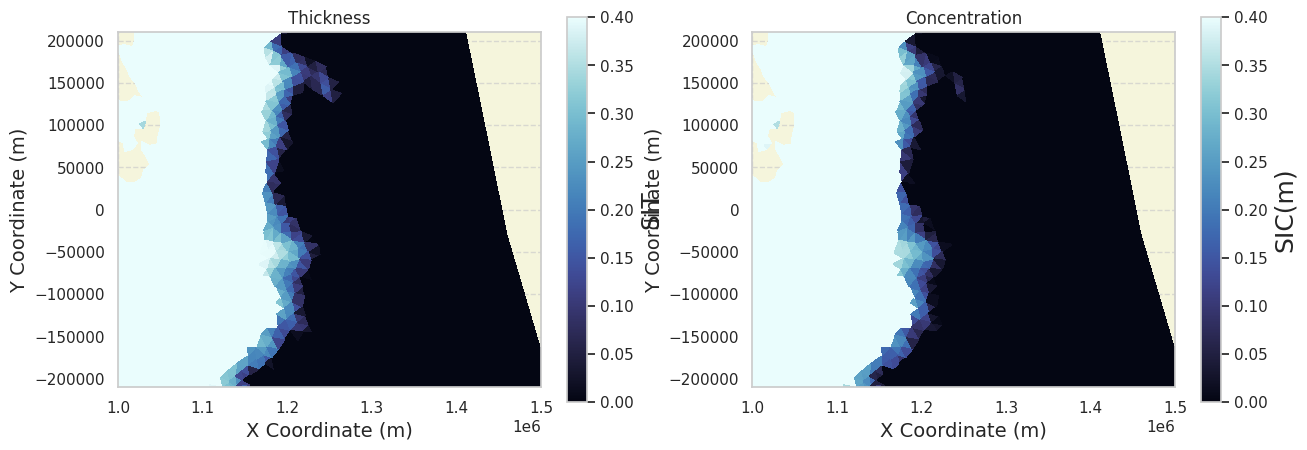

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
im0 = ax[0].tripcolor(x1n, y1n, sic1, triangles=t1n, cmap=cmocean.cm.ice, vmax=.4, vmin=0)
ax[0].set_title('Thickness')
ax[0].set_xlabel('X Coordinate (m)', fontsize=14)
ax[0].set_ylabel('Y Coordinate (m)', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].set_aspect('equal')
ax[0].set_facecolor('#f5f5dc')
plt.colorbar(im0, ax=ax[0], orientation='vertical', shrink=0.5).set_label('SIT', fontsize=18)
ax[0].set_xlim([1e6, 1.5e6])
ax[0].set_ylim([-0.21e6, 0.21e6])

im1 = ax[1].tripcolor(x1n, y1n, sic01, triangles=t1n, cmap=cmocean.cm.ice,vmax=.4,vmin=0)
ax[1].set_title('Concentration')
ax[1].set_xlabel('X Coordinate (m)', fontsize=14)
ax[1].set_ylabel('Y Coordinate (m)', fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].set_aspect('equal')
ax[1].set_facecolor('#f5f5dc')
plt.colorbar(im1, ax=ax[1], orientation='vertical', shrink=0.5).set_label('SIC(m)', fontsize=18)
ax[1].set_xlim([1e6, 1.5e6])
ax[1].set_ylim([-0.21e6, 0.21e6])


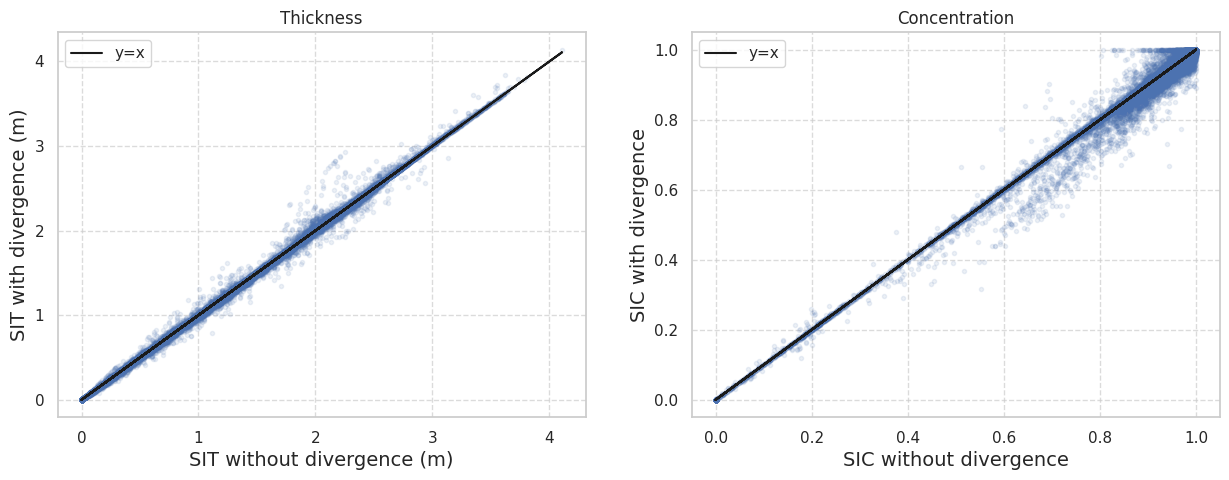

In [16]:
# compare SIC with and without accounting for divergence
#plt.plot(sit01, sit01comp, '.', alpha=0.1)
#plt.plot(sit01, sit01, 'k-')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(sit01, sit01comp, '.', alpha=0.1)
ax[0].plot(sit01, sit01, 'k-', label='y=x')
ax[0].set_xlabel('SIT without divergence (m)', fontsize=14)
ax[0].set_ylabel('SIT with divergence (m)', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()
ax[0].set_title('Thickness')

ax[1].plot(sic01, sic01comp, '.', alpha=0.1)
ax[1].plot(sic01, sic01, 'k-', label='y=x')
ax[1].set_xlabel('SIC without divergence', fontsize=14)
ax[1].set_ylabel('SIC with divergence', fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()
ax[1].set_title('Concentration')

plt.show()


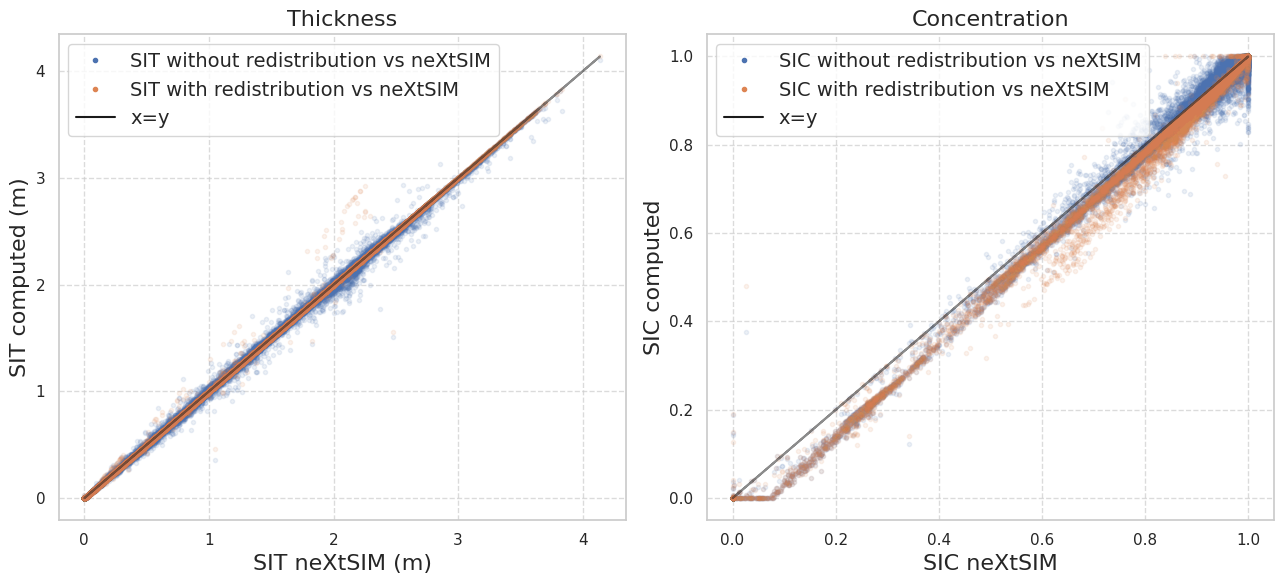

In [31]:
# compare SIT with and without accounting for divergence with the neXtSIM simulated one
#plt.plot(sit1, sit01, '.', alpha=0.1, label='SIT without divergence vs neXtSIM')
#plt.plot(sit1, sit01comp, '.', alpha=0.1, label='SIT with divergence vs neXtSIM')
#plt.plot(sit1, sit1, 'k-', label='neXtSIM SIC')
#plt.xlabel('SIT neXtSIM')
#plt.ylabel('SIT computed')
#plt.legend()


fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].plot(sit1, sit01, '.', alpha=0.1, label='SIT without redistribution vs neXtSIM')
ax[0].plot(sit1, sit01comp, '.', alpha=0.1, label='SIT with redistribution vs neXtSIM')
ax[0].plot(sit1, sit1, 'k-', label='x=y',alpha=0.5)
ax[0].set_xlabel('SIT neXtSIM (m)', fontsize=16)
ax[0].set_ylabel('SIT computed (m)', fontsize=16)
leg = ax[0].legend(fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].set_title('Thickness', fontsize=16)

for lh in leg.legend_handles:
    lh.set_alpha(1)

ax[1].plot(sic1, sic01, '.', alpha=0.1, label='SIC without redistribution vs neXtSIM')
ax[1].plot(sic1, sic01comp, '.', alpha=0.1, label='SIC with redistribution vs neXtSIM')
ax[1].plot(sic1, sic1, 'k-', label='x=y',alpha=0.5)
ax[1].set_xlabel('SIC neXtSIM', fontsize=16)
ax[1].set_ylabel('SIC computed', fontsize=16)
leg = ax[1].legend(fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].set_title('Concentration', fontsize=16)

for lh in leg.legend_handles:
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

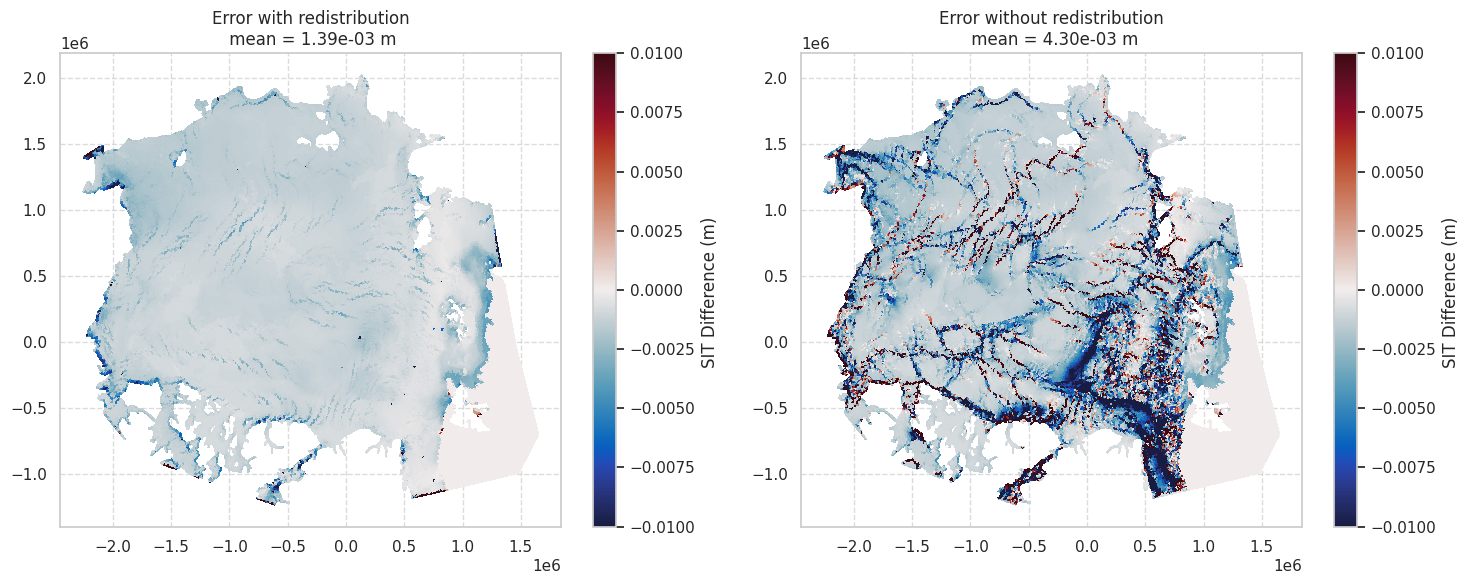

In [36]:
error_div =  sit01comp - sit1
error_no_div = sit01 - sit1

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
im0 = ax[0].tripcolor(x1n, y1n, error_div, triangles=t1n, cmap=cmocean.cm.balance, vmin=-0.01, vmax=0.01)
ax[0].set_title('Error with redistribution\n mean = {:.2e} m'.format(np.nanmean(np.abs(error_div))))
plt.colorbar(im0, ax=ax[0],label='SIT Difference (m) ')
#grid lines
ax[0].grid(True, linestyle='--', alpha=0.7)

#beige back


im1 = ax[1].tripcolor(x1n, y1n, error_no_div, triangles=t1n, cmap=cmocean.cm.balance, vmin=-0.01, vmax=0.01)
ax[1].set_title('Error without redistribution\n mean = {:.2e} m'.format(np.nanmean(np.abs(error_no_div))))
plt.colorbar(im1, ax=ax[1],label='SIT Difference (m) ')
#grid
ax[1].grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

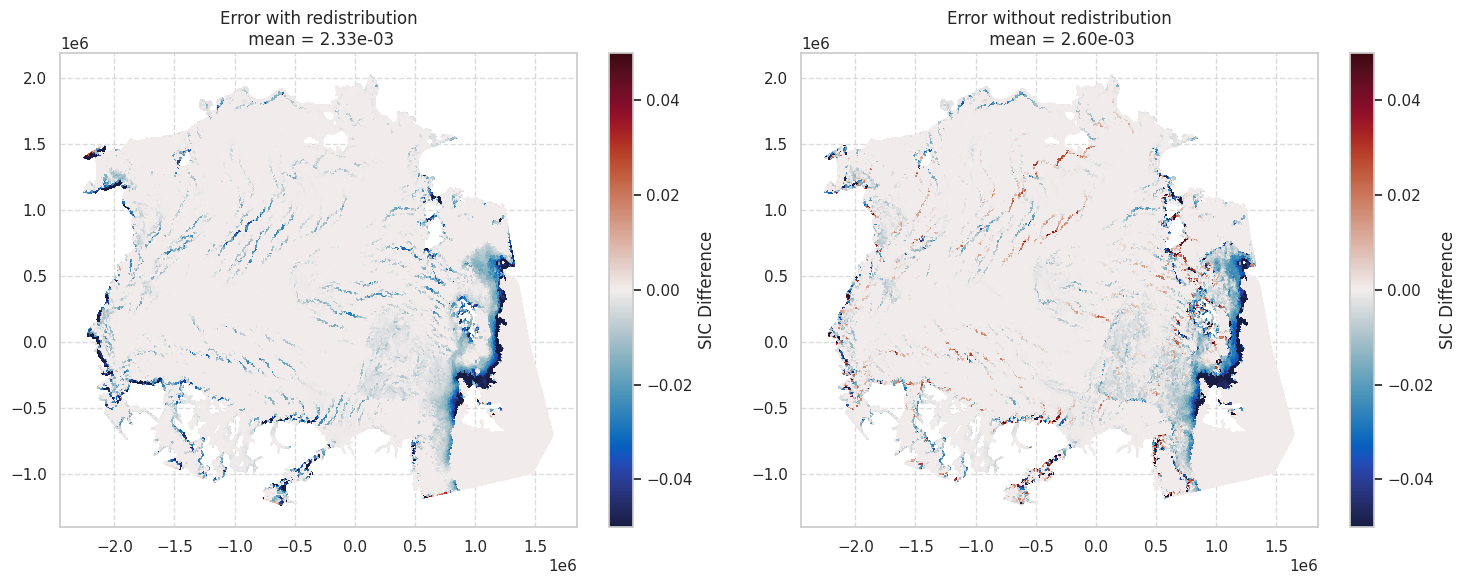

In [33]:
error_div =  sic01comp - sic1
error_no_div = sic01 - sic1

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

im0 = ax[0].tripcolor(x1n, y1n, error_div, triangles=t1n, cmap=cmocean.cm.balance, vmin=-0.05, vmax=0.05)
ax[0].set_title('Error with redistribution\n mean = {:.2e}'.format(np.nanmean(np.abs(error_div))))
plt.colorbar(im0, ax=ax[0],label='SIC Difference')
#grid
ax[0].grid(True, linestyle='--', alpha=0.7)

im1 = ax[1].tripcolor(x1n, y1n, error_no_div, triangles=t1n, cmap=cmocean.cm.balance, vmin=-0.05, vmax=0.05)
ax[1].set_title('Error without redistribution\n mean = {:.2e}'.format(np.nanmean(np.abs(error_no_div))))
plt.colorbar(im1, ax=ax[1],label='SIC Difference')
#grid
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

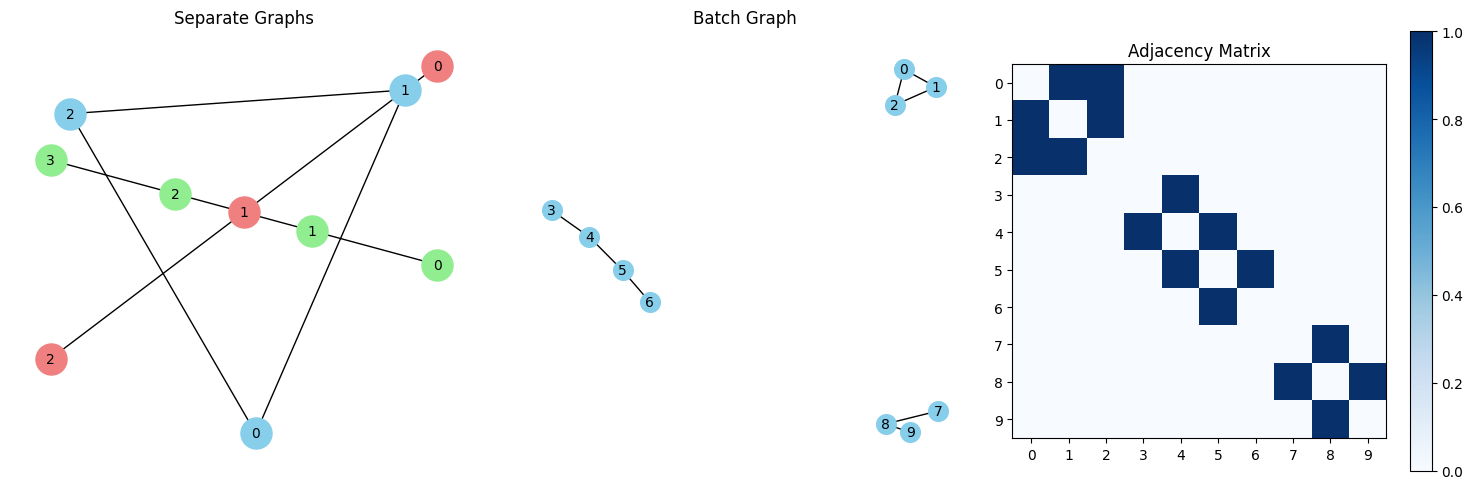

In [54]:
# Create a function to plot graphs and their adjacency matrices with node labels
def plot_graph_and_adjacency_with_labels():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Define separate graphs
    G1 = nx.Graph()
    G1.add_edges_from([(0, 1), (1, 2), (2, 0)])

    G2 = nx.Graph()
    G2.add_edges_from([(0, 1), (1, 2), (2, 3)])

    G3 = nx.Graph()
    G3.add_edges_from([(0, 1), (1, 2)])

    # Plot the separate graphs
    pos1 = nx.spring_layout(G1)
    pos2 = nx.spring_layout(G2)
    pos3 = nx.spring_layout(G3)

    axs[0].set_title("Separate Graphs")
    nx.draw(G1, pos1, ax=axs[0], with_labels=True, node_color='skyblue', edge_color='black', node_size=500, font_size=10)
    nx.draw(G2, pos2, ax=axs[0], with_labels=True, node_color='lightgreen', edge_color='black', node_size=500, font_size=10)
    nx.draw(G3, pos3, ax=axs[0], with_labels=True, node_color='lightcoral', edge_color='black', node_size=500, font_size=10)

    # Create a disconnected batch graph
    G_batch = nx.disjoint_union_all([G1, G2, G3])

    # Plot the batch graph
    pos_batch = nx.spring_layout(G_batch)
    axs[1].set_title("Batch Graph")
    nx.draw(G_batch, pos_batch, ax=axs[1], with_labels=True, node_color='skyblue', edge_color='black', node_size=200, font_size=10)

    # Create and plot the adjacency matrix of the batch graph
    adj_matrix = nx.adjacency_matrix(G_batch).todense()
    axs[2].set_title("Adjacency Matrix")
    cax = axs[2].imshow(adj_matrix, cmap='Blues')
    
    # Add node labels as x, y ticks
    node_labels = list(G_batch.nodes())
    axs[2].set_xticks(range(len(node_labels)))
    axs[2].set_yticks(range(len(node_labels)))
    axs[2].set_xticklabels(node_labels)
    axs[2].set_yticklabels(node_labels)

    plt.colorbar(cax, ax=axs[2])
    plt.tight_layout()
    plt.show()

plot_graph_and_adjacency_with_labels()
